# Projet P6 - Classifiez automatiquement des biens de consommation  *Partie 5 : Classification supervisée - Entraînement du modèle DenseNet*
*OPENCLASSROOMS - Parcours Data Scientist - Adeline Le Ray - 05/2024*
<hr>

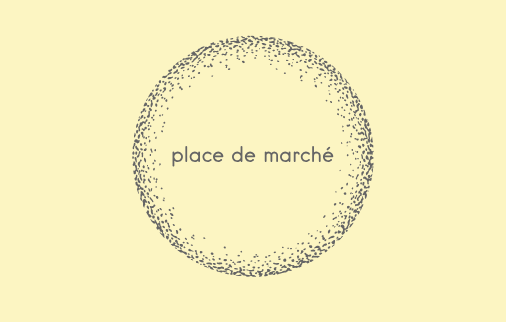

## <font color='#46abe6'>Contexte</font>
* **Projet**

Place de marché est un site de e-commerce où des vendeurs proposent des articles à des acheteurs en postant une photo et une description.
 
Actuellement, l'attribution de la catégorie d'un article est effectuée manuellement par les vendeurs, et est donc peu fiable. De plus, le volume des articles est pour l’instant très petit.
 
Pour rendre l’expérience utilisateur des vendeurs (faciliter la mise en ligne de nouveaux articles) et des acheteurs (faciliter la recherche de produits) la plus fluide possible, et dans l'optique d'un passage à l'échelle,  il devient nécessaire d'automatiser cette tâche d‘attribution de la catégorie.
 
L'objectif de ce projet est d'étudier la faisablité d'un moteur de classification à partir de la description textuelle ou de l'image du produit.

* **Notebook**

Le présent notebook porte sur l'entraînement du modèle DenseNet avec et sans data augmentation.

## <font color='#46abe6'>Sommaire</font>

<span style='background:#46abe6'><span style='color:white'>**Partie 1 - Données textuelles - Analyse exploratoire des données**</span></span>

<span style='background:#46abe6'><span style='color:white'>**Partie 2 - Données textuelles - Feature extraction et faisabilité**</span></span>

<span style='background:#46abe6'><span style='color:white'>**Partie 3 - Images - Analyse exploratoire des données**</span></span>

<span style='background:#46abe6'><span style='color:white'>**Partie 4 - Images - Feature extraction et faisabilité**</span></span>

<span style='background:#d5155b'><span style='color:white'>**Partie 5 - Images - Classification**</span></span>

[Importation des librairies + fonctions + données](#1)

[Préparation des données](#2)
* [Split Train, validation and test avec stratification sur les catégories](#2_1)
* [Classement des images dans des dossiers par catégorie](#2_2)
* [Chargement des datasets](#2_3)
* [Data augmentation](#2_4)  

[Classification supervisée - Transfert Learning - DenseNet](#3)
* [Preprocessing des datasets](#3_1)
* [Optimisation de l'hyperparamètres Batch size](#3_2)
* [VGG16 - Dataset sans data augmentation, weights = 'imagenet'](#3_3)
* [VGG16 - Dataset avec data augmentation, weights = 'imagenet'](#3_4)

<span style='background:#46abe6'><span style='color:white'>**Partie 6 - Images - Requête API**</span></span></span>

# <font color='#0a389f'>Importation librairies + fonctions + données<a class="anchor" id="1"></a></font>

## <font color='#46abe6'>Importation des librairies<a class="anchor" id="1_1"></a></font>

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import os
import shutil
from tqdm import tqdm
import time
import pickle

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Input, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications.densenet import DenseNet201, preprocess_input
from tensorflow.keras.optimizers import Adam

In [2]:
# Version python
!python --version
# Version des librairies utilisées
print('\n'.join(f'{m.__name__} - {m.__version__}' 
                for m in globals().values() 
                if getattr(m, '__version__', None)))

Python 3.11.4
numpy - 1.24.4
pandas - 2.2.2
tensorflow - 2.16.1


## <font color='#46abe6'>Fonctions<a class="anchor" id="1_2"></a></font>

In [3]:
def preprocess_image(image, label):
    """!
    @brief Preorocess une image en appliquant une normalisation spécifique au modèle DenseNet.

    Cette fonction prend une image et son label, applique la fonction de prétraitement `preprocess_input`
    (spécifique au modèle DenseNet), et retourne l'image prétraitée avec son label.

    @param image: Image d'entrée sous forme de tableau numpy ou de tenseur (type: tf.Tensor).
    @param label: Label associé à l'image, sous forme de tenseur (type: tf.Tensor).

    @return (image, label): Une tuple contenant l'image prétraitée et son label (type: tuple).
    """
    image = preprocess_input(image)
    
    return image, label

In [4]:
def preprocess_datasets(train_dataset, validation_dataset, test_dataset):
    """ !
    @brief Preprocessing et improvement des datasets   
    Prétraiter les ensembles de données pour le modèle en appliquant une fonction de prétraitement 
    et en utilisant des techniques de chevauchement pour optimiser les performances.
    Cette fonction utilise la fonction preprocess_image.

    @ param train_dataset: L'ensemble de données d'entraînement (type: tf.data.Dataset).
    @param validation_dataset: L'ensemble de données de validation (type: tf.data.Dataset).
    @param test_dataset: L'ensemble de données de test (type: tf.data.Dataset).

    @ return: Ensemble de données d'entraînement, de validation et de test prétraités (type : tuple).
    """

    # Appliquer le prétraitement aux ensembles de données
    train_dataset_p = train_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    validation_dataset_p = validation_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    test_dataset_p = test_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

    # Dataset.cache stocke les résultats d'un calcul en mémoire pour éviter de les recalculer à chaque epoch
    # Dataset.prefetch chevauche le prétraitement des données et l'exécution du modèle pendant la formation
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    train_dataset_p = train_dataset_p.cache().prefetch(buffer_size=AUTOTUNE)
    validation_dataset_p = validation_dataset_p.cache().prefetch(buffer_size=AUTOTUNE)
    test_dataset_p = test_dataset_p.cache().prefetch(buffer_size=AUTOTUNE)

    return train_dataset_p, validation_dataset_p, test_dataset_p

In [5]:
def create_model(model, weights):
    """!
    @brief Crée et compile un modèle de deep learning basé sur DenseNet201 pour une tâche de classification.

    Cette fonction initialise un modèle VGG16 ou DenseNet201 pré-entraîné sans les couches de classification finales,
    ajoute des couches de pooling, des couches entièrement connectées, et une couche de sortie avec une activation
    softmax pour prédire les classes. Les couches du modèle de base sont gelées pour utiliser le transfert d'apprentissage.

    @param model: modèle VGG16 ou DenseNet201 (type: str)
    @param weights: Poids à utiliser pour le modèle pré-entraîné (type: str).
    ('imagenet' pour utiliser les poids pré-entraînés sur ImageNet ou None pour un entraînement à partir de zéro) 
    
    @return model: Le modèle compilé prêt à l'entraînement (type: tensorflow.keras.Model).
    """
    # Chargement du modèle VGG16 ou DenseNet sans les couches de classification finales
    if model=='VGG16':
        base_model = VGG16(weights=weights, include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    elif model=='DenseNet':
        base_model = DenseNet201(weights=weights, include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    else:
        raise ValueError("Le modèle spécifié doit être 'VGG16' ou 'DenseNet'.")
    
    # Ajout de couches au modèle
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Applique un pooling global moyen
    x = Dense(512, activation='relu')(x)  # Ajoute une couche dense avec 512 unités et activation ReLU
    x = Dropout(0.5)(x)  # Applique un dropout de 50% pour régularisation
    predictions = Dense(7, activation='softmax')(x)  # Couche de sortie pour 7 classes avec activation softmax

    # Créer le modèle complet
    model = Model(inputs=base_model.input, outputs=predictions)

    # Congeler les couches du modèle de base pour le transfert d'apprentissage
    for layer in base_model.layers:
        layer.trainable = False

    # Compiler le modèle avec un optimiseur Adam et une perte de catégorisation croisée
    model.compile(
        optimizer=Adam(),
        loss='categorical_crossentropy', 
        metrics=['accuracy']
    )
    
    return model

In [6]:
def create_model_data_augm(model, weights, data_augmentation):
    """!
    @brief Crée et compile un modèle de deep learning basé sur DenseNet201 pour une tâche de classification.

    Cette fonction initialise un modèle DenseNet201 pré-entraîné sans les couches de classification finales,
    ajoute des couches de pooling, des couches entièrement connectées, et une couche de sortie avec une activation
    softmax pour prédire les classes. Les couches du modèle de base sont gelées pour utiliser le transfert d'apprentissage.
    
    @param model: modèle VGG16 ou DenseNet201 (type: str)
    @param weights: Poids à utiliser pour le modèle pré-entraîné (type: str).
    ('imagenet' pour utiliser les poids pré-entraînés sur ImageNet ou None pour un entraînement à partir de zéro) 
    @
    
    @return model: Le modèle compilé prêt à l'entraînement (type: tensorflow.keras.Model).
    """
    # Chargement du modèle VGG16 ou DenseNet sans les couches de classification finales
    if model=='VGG16':
        cnn_model = VGG16(weights=weights, include_top=False)
    elif model=='DenseNet':
        cnn_model = DenseNet201(weights=weights, include_top=False)
    else:
        raise ValueError("Le modèle spécifié doit être 'VGG16' ou 'DenseNet'.") 
        
    input_layer = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    base_model = Sequential([
                        input_layer,
                        data_augmentation,
                        cnn_model
        ], name="base_model")

    # Congeler les couches du modèle de base pour le transfert d'apprentissage
    for layer in base_model.layers:
        layer.trainable = False
    
    # Afficher la structure du modèle
    print(base_model.summary())

    # Ajout de couches au modèle
    model = Sequential([
            input_layer,
            base_model, # Modèle DenseNet avec data augmentation des images
            GlobalAveragePooling2D(), # Applique un pooling global moyen
            Dense(512, activation='relu'), # Ajoute une couche dense avec 512 unités et activation ReLU
            Dropout(0.5), # Applique un dropout de 50% pour régularisation
            Dense(7, activation='softmax') # Couche de sortie pour 7 classes avec activation softmax
            ], name = "model")

   # Compiler le modèle avec un optimiseur Adam et une perte de catégorisation croisée
    model.compile(
        optimizer=Adam(),
        loss='categorical_crossentropy', 
        metrics=['accuracy']
    )
    
    # Afficher la structure du modèle
    print(model.summary())
    
    return model

## <font color='#46abe6'>Importation des données<a class="anchor" id="1_3"></a></font>

In [7]:
# Importation des données
data = pd.read_pickle('image_data.pkl')
display(data.head())

,uniq_id,image,main_category,sub_category,main_category_label
0,55b85ea15a1536d46b7190ad6fff8ce7,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,Curtains & Accessories,4
1,7b72c92c2f6c40268628ec5f14c6d590,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,Baby Bath & Skin,0
2,64d5d4a258243731dc7bbb1eef49ad74,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,Baby Bath & Skin,0
3,d4684dcdc759dd9cdf41504698d737d8,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,Bed Linen,4
4,6325b6870c54cd47be6ebfbffa620ec7,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,Bed Linen,4


In [8]:
# liste des noms des images
list_images = data['image'].values

# liste catégories
l_cat =  np.sort(data["main_category"].unique())

# <font color='#0a389f'>Préparation des données<a class="anchor" id="2"></a></font>

In [9]:
# initialisation de eval_df
eval_df = pd.DataFrame()

In [10]:
# Paramètres
BATCH_SIZE = 32
IMG_WIDTH = 224
IMG_HEIGHT = 224
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
COLOR_MODE = 'rgb'
SEED = 42
EPOCHS = 50

# Chemin du répertoire source des images 
image_path = 'C:/Users/Adeline/OneDrive/Documents/5-Openclassrooms/Parcours DS/P6/Dataset+projet+prétraitement+textes+images/Flipkart/Images/'

# Répertoire où stocker les images triées par catégorie
destination_path = 'C:/Users/Adeline/Documents/5-OpenClassrooms/Parcours DS/P6/Images'
train_directory = os.path.join(destination_path, 'train')
val_directory = os.path.join(destination_path, 'validation')
test_directory = os.path.join(destination_path, 'test')

save_path = 'C:/Users/Adeline/OneDrive/Documents/5-Openclassrooms/Parcours DS/P6/best_model'

## <font color='#46abe6'>Split Train, validation and test avec stratification sur les catégories<a class="anchor" id="2_1"></a></font>

In [11]:
# Avec train_test_split
X = data['image']
y = data['main_category']

TEST_SIZE = 0.2
VAL_SIZE = 0.2

# Train, validation and test datasets
train_df, test_df = train_test_split(data, stratify=y, test_size=TEST_SIZE, random_state=SEED)
train_df, val_df = train_test_split(train_df, stratify=train_df['main_category'], test_size=VAL_SIZE, random_state=SEED)

print(f'Dimensions train: {train_df.shape[0]}')
print(f'Dimensions val : {val_df.shape[0]}')
print(f'Dimensions test : {test_df.shape[0]}')

Dimensions train: 672
Dimensions val : 168
Dimensions test : 210


## <font color='#46abe6'>Classement des images dans des dossiers par catégorie
<a class="anchor" id="2_2"></a></font>

Pour utiliser [tf.keras.preprocessing.image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory), il est nécessaire que les données soient classées dans des dossiers avec la structure suivante : 
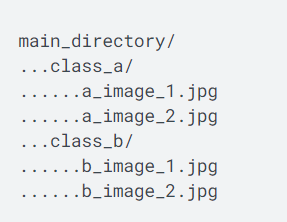

Nous allons donc organiser les images de cette façon.

In [12]:
# Créer les sous-dossiers catégorie
for folder in ('train', 'validation', 'test'):
    for cat in l_cat:
        # Nom du dossier catégorie
        folder_path = os.path.join(destination_path, folder, cat)  
        # Créer le dossier s'il n'existe pas
        os.makedirs(folder_path, exist_ok=True)

In [13]:
# Iteration sur chaque ligne du dataframe pour copier les images dans le dossier catégorie correspondant
for folder, df in zip(('train', 'validation', 'test'), (train_df, val_df, test_df)):
    for index, row in tqdm(df.iterrows()):
        label = row['main_category']
        image = row['image']

        input_path = os.path.join(image_path, image)
        output_path = os.path.join(destination_path, folder, label, image)

        # Vérifiez si le fichier existe déjà avant de le copier
        if not os.path.exists(output_path):
            shutil.copyfile(input_path, output_path)

672it [00:00, 4304.89it/s]
168it [00:00, 5681.05it/s]
210it [00:00, 6987.68it/s]


## <font color='#46abe6'>Chargement des datasets<a class="anchor" id="2_3"></a></font>

* **Chargement des datasets**

In [14]:
# Chargement des différents datasets : Train, validation et test
train_dataset = image_dataset_from_directory(train_directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             color_mode=COLOR_MODE,
                                             seed=SEED,
                                             label_mode='categorical')

validation_dataset = image_dataset_from_directory(val_directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             color_mode=COLOR_MODE,     
                                             seed=SEED,
                                             label_mode='categorical') 

test_dataset = image_dataset_from_directory(test_directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             color_mode=COLOR_MODE,     
                                             seed=SEED,
                                             label_mode='categorical')

Found 672 files belonging to 7 classes.
Found 168 files belonging to 7 classes.
Found 210 files belonging to 7 classes.


In [15]:
# Noms de classe
class_names = train_dataset.class_names
print(class_names)

['Baby Care', 'Beauty and Personal Care', 'Computers', 'Home Decor & Festive Needs', 'Home Furnishing', 'Kitchen & Dining', 'Watches']


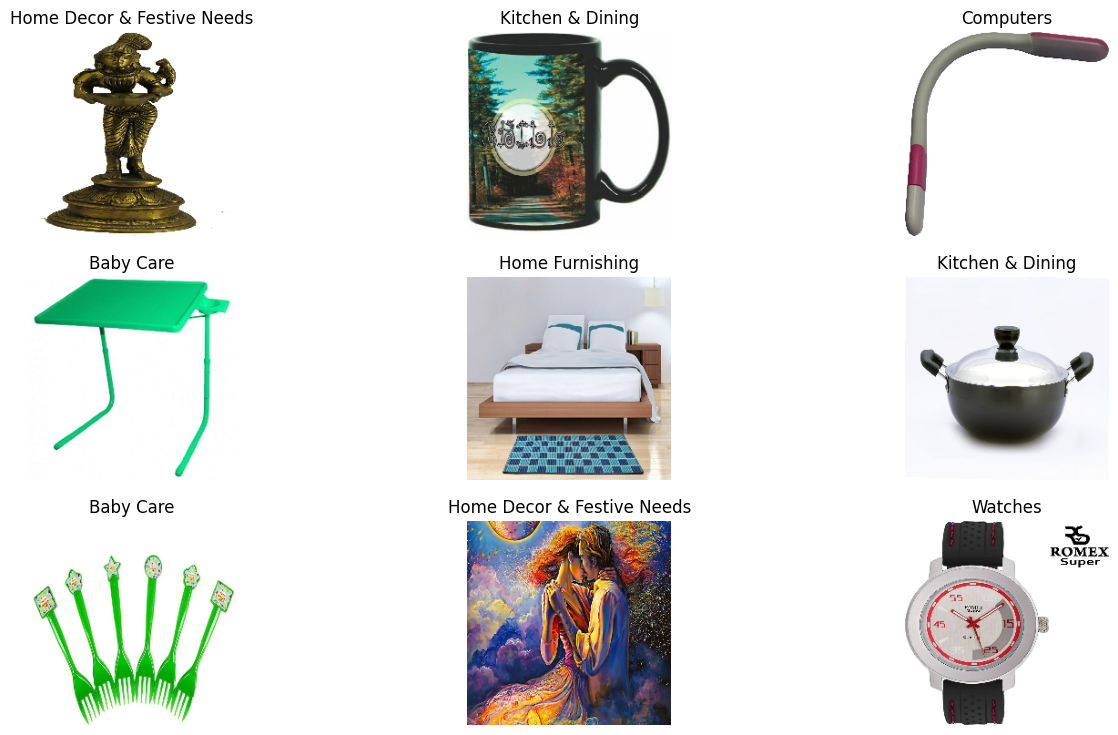

In [16]:
# Visualisation des données
plt.figure(figsize=(16, 9))
for images, labels in train_dataset.take(1):
    for i in range(9):
        num_cat = np.argmax(labels[i].numpy())
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"{class_names[num_cat]}")
        plt.axis("off")

## <font color='#46abe6'>Data augmentation<a class="anchor" id="2_4"></a></font>

Pour la data augmentation, nous utiliserons la transformation des images disponibles. Les transformation possibles sont par exemple:
* Miroir
* Rotation
* Zoom
* Resize
* Ajout de bruit
* Luminosité / contraste

Les images à disposition sont de bonne qualité : il n'est pas utile d'ajouter du bruit pour la data augmentation.

In [17]:
# Définir la forme de l'entrée via une couche Input
input_layer = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Appliquer l'augmentation des données
data_augmentation = Sequential(
    [
        input_layer,
        RandomFlip(mode="horizontal"),
        RandomRotation(0.1),
        RandomZoom(0.1)
    ],
    name="Augmentation"
)

# Summary
print(data_augmentation.summary())

Model: "Augmentation"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 224, 224, 3)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


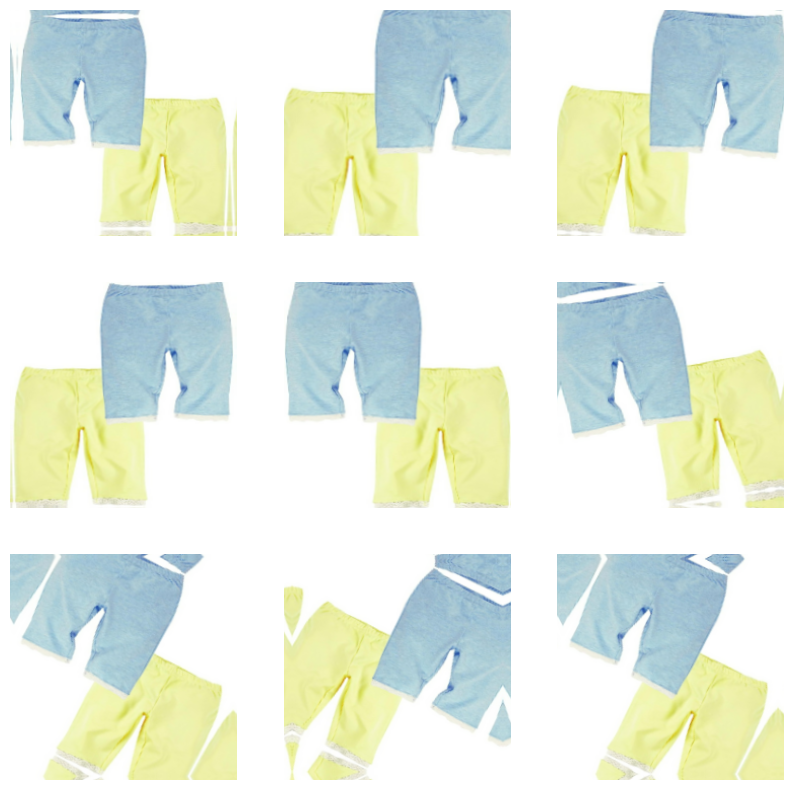

In [18]:
# Exemples d'images avant / après data augmentation
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

# <font color='#0a389f'>Classification supervisée - transfer learning - DenseNet<a class="anchor" id="3"></a></font>

L'**accuracy** (précision) est la métrique choisie pour évaluer la performance des modèles de classification. Elle mesure la proportion de prédictions correctes effectuées par le modèle par rapport au nombre total de prédictions.
Dans notre cas, les classes sont équilibrées donc cette metrique reste pertinente.

La fonction loss retenue est **CategoricalCrossentropy** : nombre de classes > 2, classe de type categorical.

Ressources :
Ressources :
* [Exemple 1 de transfer learning](https://khawlajlassi.medium.com/a-guide-to-transfer-learning-with-keras-using-densenet201-48c617ceb2e2)
* [Exemple 2 de transfer learning](https://medium.com/@zeynepaslann/transfer-learning-using-densenet201-525749762ca9)
* [tf : Apprentissage par transfert et mise au points](https://www.tensorflow.org/guide/keras/transfer_learning?hl=fr)
* [tf : Apprentissage par transfert et perfectionnement](https://www.tensorflow.org/tutorials/images/transfer_learning?hl=fr)
* [tf :Charger et prétraiter les images](https://www.tensorflow.org/tutorials/load_data/images?hl=fr)
* [tf: Entraînement et évaluation](https://www.tensorflow.org/guide/keras/training_with_built_in_methods)

## <font color='#46abe6'>Preprocessing des datasets<a class="anchor" id="3_1"></a></font>

In [19]:
# Preprocessing des images
train_dataset_dense, validation_dataset_dense, test_dataset_dense = preprocess_datasets(
    train_dataset, validation_dataset, test_dataset
)

## <font color='#46abe6'>Optimisation de l'hyperparamètres Batch size<a class="anchor" id="3_2"></a></font>

In [20]:
# Taille de batch à tester
batch_sizes = [16, 32, 64]

# Variable pour stocker les résultats
results = {}

# Boucle pour tester chaque taille de batch
for batch_size in batch_sizes:
    print(f"Training with batch size: {batch_size}")
    
    model = create_model('DenseNet', 'imagenet')
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    
    # Entraînement du modèle
    history = model.fit(train_dataset_dense, 
                        validation_data=validation_dataset_dense, 
                        epochs=10, 
                        batch_size=batch_size, 
                        callbacks=[early_stopping], 
                        verbose=1)
    
    val_accuracy = max(history.history['val_accuracy'])
    results[batch_size] = val_accuracy

# Afficher les résultats
print("Résultats de l'optimisation de la taille du batch :")
for batch_size, val_accuracy in results.items():
    print(f"Batch Size: {batch_size}, Validation Accuracy: {val_accuracy:.4f}")

# Trouver la meilleure taille de batch
best_batch_size = max(results, key=results.get)
print(f"La meilleure taille de batch est : {best_batch_size} avec une accuracy de validation de {results[best_batch_size]:.3f}")

BATCH_SIZE = best_batch_size

Training with batch size: 16
Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.4518 - loss: 1.7031 - val_accuracy: 0.8095 - val_loss: 0.5864
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.8728 - loss: 0.4009 - val_accuracy: 0.8214 - val_loss: 0.5423
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.9108 - loss: 0.2910 - val_accuracy: 0.8452 - val_loss: 0.5261
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.9374 - loss: 0.1995 - val_accuracy: 0.8393 - val_loss: 0.4959
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.9403 - loss: 0.1854 - val_accuracy: 0.8631 - val_loss: 0.4756
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.9618 - loss: 0.1218 - val_accuracy: 0.8631 - val_loss: 0.5013
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.9657 - loss: 0.0921 - val_accuracy: 0.8571 - val_loss: 0.5145
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.9767 - loss: 0.0714 - val

## <font color='#46abe6'>DenseNet - Dataset sans data augmentation, weights = None<a class="anchor" id="3_3"></a></font>

### Chargement du modèle

In [21]:
# Création du modèle 
model_noweights = create_model('DenseNet', None)

### Définition des callbacks

In [22]:
# EarlyStopping pour arrêter l'entraînement en monitorant la val_loss et éviter le surapprentissage
early = EarlyStopping(
    monitor="val_loss",  # Surveillance de la perte de validation
    patience=5  # Patience en nombre d'époques avant d'arrêter
)

# ModelCheckPoint pour sauver le modèle avec la meilleure val_accuracy
noweights_save_path = os.path.join(save_path,'best_model_noweight.keras')

modelcheck = ModelCheckpoint(
    noweights_save_path, 
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

### Entraînement du modèle

In [23]:
# Relevé temps début entraînement
start_time = time.perf_counter()

# Entraînement
history_noweights = model_noweights.fit(
    train_dataset_dense, 
    validation_data=validation_dataset_dense, 
    epochs=EPOCHS,
    callbacks=[modelcheck, early],
    verbose=1
)

# Relevé temps fin entraînement
end_time = time.perf_counter()
fit_time = round(end_time - start_time, 2)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1089 - loss: 1.9790
Epoch 1: val_accuracy improved from -inf to 0.14286, saving model to C:/Users/Adeline/OneDrive/Documents/5-Openclassrooms/Parcours DS/P6/best_model\best_model_noweight.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.1092 - loss: 1.9791 - val_accuracy: 0.1429 - val_loss: 1.9500
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1287 - loss: 1.9785
Epoch 2: val_accuracy improved from 0.14286 to 0.16071, saving model to C:/Users/Adeline/OneDrive/Documents/5-Openclassrooms/Parcours DS/P6/best_model\best_model_noweight.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.1294 - loss: 1.9781 - val_accuracy: 0.1607 - val_loss: 1.9282
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1850 - loss: 1.9319
Epoch 3: val_accuracy improved from 0.16071 to 0.22024, saving model to C:/Users/Adeline/OneDrive/Documents/5-Openclassrooms/Parcours DS/P6/best_model\best_model_noweight

Epoch 24/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2596 - loss: 1.8001
Epoch 24: val_accuracy did not improve from 0.35119
21/21 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.2599 - loss: 1.8002 - val_accuracy: 0.2857 - val_loss: 1.7882
Epoch 25/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3202 - loss: 1.7960
Epoch 25: val_accuracy did not improve from 0.35119
21/21 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - accuracy: 0.3197 - loss: 1.7960 - val_accuracy: 0.3333 - val_loss: 1.7742
Epoch 26/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2812 - loss: 1.7864
Epoch 26: val_accuracy improved from 0.35119 to 0.36905, saving model to C:/Users/Adeline/OneDrive/Documents/5-Openclassrooms/Parcours DS/P6/best_model\best_model_noweight.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - accuracy: 0.2825 - loss: 1.7863 - val_accuracy: 0.3690 - val_loss: 1.7675
Epoch 27/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3107 - loss: 1.7727
Epoch 27: val_accuracy did not improv

In [24]:
# Sauvegarde de l'objet history dans un fichier
history_dict = history_noweights.history
history_dict['training_time'] = fit_time

## <font color='#46abe6'>DenseNet - Dataset avec data augmentation, weights = None<a class="anchor" id="3_4"></a></font>

### Chargement du modèle

In [26]:
# Création du modèle 
model_noweights_augm = create_model_data_augm('DenseNet', None, data_augmentation)

Model: "base_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Augmentation (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet201 (Functional)        │ (None, 7, 7, 1920)     │    18,321,984 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,321,984 (69.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 18,321,984 (69.89 MB)

None


Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ base_model (Sequential)         │ (None, 7, 7, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1920)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │       983,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,309,127 (73.66 MB)

 Trainable params: 987,143 (3.77 MB)

 Non-trainable params: 18,321,984 (69.89 MB)

None


### Définition des callbacks

In [27]:
# EarlyStopping pour arrêter l'entraînement en monitorant la val_loss et éviter le surapprentissage
early = EarlyStopping(
    monitor="val_loss",  # Surveillance de la perte de validation
    patience=5  # Patience en nombre d'époques avant d'arrêter
)

# ModelCheckPoint pour sauver le modèle avec la meilleure val_accuracy
noweights_augm_save_path = os.path.join(save_path,'best_model_noweights_augm.keras')

modelcheck = ModelCheckpoint(
    noweights_augm_save_path, 
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

### Entraînement du modèle

In [28]:
# Relevé temps début entraînement
start_time = time.perf_counter()

# Entraînement
history_noweights_augm = model_noweights_augm.fit(
    train_dataset_dense, 
    validation_data=validation_dataset_dense, 
    epochs=EPOCHS,
    callbacks=[modelcheck, early],
    verbose=1
)

# Relevé temps fin entraînement
end_time = time.perf_counter()
fit_time = round(end_time - start_time, 2)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1515 - loss: 1.9568
Epoch 1: val_accuracy improved from -inf to 0.19643, saving model to C:/Users/Adeline/OneDrive/Documents/5-Openclassrooms/Parcours DS/P6/best_model\best_model_noweights_augm.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.1517 - loss: 1.9569 - val_accuracy: 0.1964 - val_loss: 1.9350
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1340 - loss: 1.9518
Epoch 2: val_accuracy improved from 0.19643 to 0.21429, saving model to C:/Users/Adeline/OneDrive/Documents/5-Openclassrooms/Parcours DS/P6/best_model\best_model_noweights_augm.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.1345 - loss: 1.9517 - val_accuracy: 0.2143 - val_loss: 1.9205
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1918 - loss: 1.9296
Epoch 3: val_accuracy improved from 0.21429 to 0.23214, saving model to C:/Users/Adeline/OneDrive/Documents/5-Openclassrooms/Parcours DS/P6/best_model\best_mo

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3351 - loss: 1.7478
Epoch 48: val_accuracy did not improve from 0.38095
21/21 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.3340 - loss: 1.7488 - val_accuracy: 0.3333 - val_loss: 1.7712
Epoch 49/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3184 - loss: 1.7557
Epoch 49: val_accuracy did not improve from 0.38095
21/21 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - accuracy: 0.3181 - loss: 1.7560 - val_accuracy: 0.3512 - val_loss: 1.7599
Epoch 50/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3109 - loss: 1.7562
Epoch 50: val_accuracy did not improve from 0.38095
21/21 ━━━━━━━━━━━━━━━━━━━━ 57s 3s/step - accuracy: 0.3109 - loss: 1.7563 - val_accuracy: 0.3452 - val_loss: 1.7632


In [29]:
# Sauvegarde de l'objet history dans un fichier
history_dict = history_noweights_augm.history
history_dict['training_time'] = fit_time

with open('history_DenseNet_noweights_augm.pkl', 'wb') as file:
    pickle.dump(history_dict, file)

## <font color='#46abe6'>DenseNet - Dataset sans data augmentation, weights = imagenet<a class="anchor" id="3_5"></a></font>

### Chargement du modèle

In [30]:
# Création du modèle 
model_imagenet = create_model('DenseNet', 'imagenet')

### Définition des callbacks

In [31]:
# EarlyStopping pour arrêter l'entraînement en monitorant la val_loss et éviter le surapprentissage
early = EarlyStopping(
    monitor="val_loss",  # Surveillance de la perte de validation
    patience=5  # Patience en nombre d'époques avant d'arrêter
)

# ModelCheckPoint pour sauver le modèle avec la meilleure val_accuracy
imagenet_save_path = os.path.join(save_path,'best_model_imagenet.keras')

modelcheck = ModelCheckpoint(
    noweights_augm_save_path, 
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

### Entraînement du modèle

In [32]:
# Relevé temps début entraînement
start_time = time.perf_counter()

# Entraînement
history_imagenet = model_imagenet.fit(
    train_dataset_dense, 
    validation_data=validation_dataset_dense, 
    epochs=EPOCHS,
    callbacks=[modelcheck, early],
    verbose=1
)

# Relevé temps fin entraînement
end_time = time.perf_counter()
fit_time = round(end_time - start_time, 2)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4718 - loss: 1.5950
Epoch 1: val_accuracy improved from -inf to 0.79762, saving model to C:/Users/Adeline/OneDrive/Documents/5-Openclassrooms/Parcours DS/P6/best_model\best_model_noweights_augm.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.4789 - loss: 1.5747 - val_accuracy: 0.7976 - val_loss: 0.6041
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8647 - loss: 0.3937
Epoch 2: val_accuracy improved from 0.79762 to 0.83333, saving model to C:/Users/Adeline/OneDrive/Documents/5-Openclassrooms/Parcours DS/P6/best_model\best_model_noweights_augm.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - accuracy: 0.8644 - loss: 0.3953 - val_accuracy: 0.8333 - val_loss: 0.5289
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9134 - loss: 0.2764
Epoch 3: val_accuracy improved from 0.83333 to 0.84524, saving model to C:/Users/Adeline/OneDrive/Documents/5-Openclassrooms/Parcours DS/P6/best_model\best_mo

In [33]:
# Sauvegarde de l'objet history dans un fichier
history_dict = history_imagenet.history
history_dict['training_time'] = fit_time

with open('history_DenseNet_imagenet.pkl', 'wb') as file:
    pickle.dump(history_dict, file)

## <font color='#46abe6'>DenseNet - Dataset avec data augmentation, weights = imagenet<a class="anchor" id="3_6"></a></font>

### Chargement du modèle

In [34]:
# Création du modèle 
model_imagenet_augm = create_model_data_augm('DenseNet', 'imagenet', data_augmentation)

Model: "base_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Augmentation (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet201 (Functional)        │ (None, 7, 7, 1920)     │    18,321,984 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,321,984 (69.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 18,321,984 (69.89 MB)

None


Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ base_model (Sequential)         │ (None, 7, 7, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 1920)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │       983,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,309,127 (73.66 MB)

 Trainable params: 987,143 (3.77 MB)

 Non-trainable params: 18,321,984 (69.89 MB)

None


### Définition des callbacks

In [35]:
# EarlyStopping pour arrêter l'entraînement en monitorant la val_loss et éviter le surapprentissage
early = EarlyStopping(
    monitor="val_loss",  # Surveillance de la perte de validation
    patience=5  # Patience en nombre d'époques avant d'arrêter
)

# ModelCheckPoint pour sauver le modèle avec la meilleure val_accuracy
imagenet_augm_save_path = os.path.join(save_path,'best_model_imagenet_augm.keras')

modelcheck = ModelCheckpoint(
    imagenet_augm_save_path, 
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

### Entraînement du modèle

In [36]:
# Relevé temps début entraînement
start_time = time.perf_counter()

# Entraînement
history_imagenet_augm = model_imagenet_augm.fit(
    train_dataset_dense, 
    validation_data=validation_dataset_dense, 
    epochs=EPOCHS,
    callbacks=[modelcheck, early],
    verbose=1
)

# Relevé temps fin entraînement
end_time = time.perf_counter()
fit_time = round(end_time - start_time, 2)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4126 - loss: 1.7655
Epoch 1: val_accuracy improved from -inf to 0.80357, saving model to C:/Users/Adeline/OneDrive/Documents/5-Openclassrooms/Parcours DS/P6/best_model\best_model_imagenet_augm.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.4195 - loss: 1.7454 - val_accuracy: 0.8036 - val_loss: 0.6812
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8059 - loss: 0.5509
Epoch 2: val_accuracy improved from 0.80357 to 0.80952, saving model to C:/Users/Adeline/OneDrive/Documents/5-Openclassrooms/Parcours DS/P6/best_model\best_model_imagenet_augm.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - accuracy: 0.8058 - loss: 0.5529 - val_accuracy: 0.8095 - val_loss: 0.5894
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8565 - loss: 0.4468
Epoch 3: val_accuracy improved from 0.80952 to 0.82738, saving model to C:/Users/Adeline/OneDrive/Documents/5-Openclassrooms/Parcours DS/P6/best_model\best_mode

In [37]:
# Sauvegarde de l'objet history dans un fichier
history_dict = history_imagenet_augm.history
history_dict['training_time'] = fit_time

with open('history_DenseNet_imagenet_augm.pkl', 'wb') as file:
    pickle.dump(history_dict, file)